In [34]:
import torch 
import torch.nn as nn

## 1. GPT Backbone

In [35]:
GPT_CONFIG_124M = {
    "vocab_size": 50257, # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768, # Embedding dimension
    "n_heads": 12, # Number of attention heads
    "n_layers": 12, # Number of layers
    "drop_rate": 0.1, # Dropout rate
    "qkv_bias": False # Query-Key-Value bias
}

- Các thành phần của _DummyGPT_ này chúng ta đều đã tìm hiểu trong các chương trước, với _DummyTransformerBlock_ là 1 khối Transformer & _DummyLayerNorm_ là 1 lớp Layer Normalization.

In [36]:
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = DummyLayerNorm(cfg["emb_dim"]) #B
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

class DummyTransformerBlock(nn.Module): #C
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x): #D
        return x
    
class DummyLayerNorm(nn.Module): #E
    def __init__(self, normalized_shape, eps=1e-5): #F
        super().__init__()

    def forward(self, x):
        return x


## 2. Layer Normalization

- Khởi tạo random 2 vector:

In [37]:
torch.manual_seed(123)
batch = torch.randn(2, 5)
print(batch)

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])


- Sau khi đưa qua 1 lớp _Linear_ và qua hàm kích hoạt _ReLU_:

In [38]:
layer = nn.Sequential(
    nn.Linear(5, 6),
    nn.ReLU(),
)
outputs = layer(batch)
print(outputs)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


- Lớp mạng nơ-ron vừa code ở trên bao gồm _1 lớp tuyến tính_ `Linear` đi kèm với _1 hàm kích hoạt_ `ReLU` (Rectified Linear Unit).

- Hàm `ReLU` đơn giản là sẽ chặn các giá trị đầu vào âm và chuyển chúng về 0, đảm bảo rằng đầu ra của lớp chỉ chứa các giá trị dương.

- Trước khi áp dụng `Layer Normalization` cho các outputs này, cùng tính `mean` & `variance` của các outputs này trước:

In [39]:
mean = outputs.mean(dim=-1, keepdim=True)
variance = outputs.var(dim=-1, keepdim=True)
print(f"Mean:\n {mean}")
print(f"Variance:\n {variance}")

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


- Việc sử dụng `keepdim=True` trong các phép toán như `mean` & `variance` giúp chúng ta giữ nguyên số chiều như tensor đầu vào. Ví dụ nếu không có `keepdim=True`, thì _mean_ trả về sẽ là 1 tensor 2 chiều _[0.1324, 0.2170]_ thay vì 1 ma trận 2x1 _[[0.1324], [0.2170]]_.

- Tiếp theo đây là đoạn code triển khai _layer normalization_, với công thức sử dụng của [Standardization](https://tyanfarm.github.io/tyan-blog/docs/build-llm-from-scratch/bonus-section/normalization#standardization-z-score-normalization).

In [40]:
outputs_norm = (outputs - mean) / torch.sqrt(variance)
mean = outputs_norm.mean(dim=-1, keepdim=True)
variance = outputs_norm.var(dim=-1, keepdim=True)
print(f"Normalized outputs:\n {outputs_norm}")
print(f"Mean:\n {mean}")
print(f"Variance:\n {variance}")

Normalized outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[0.0000],
        [0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- Giá trị `9.9341e-09` là 9.9341 * 10^-9 = 0.0000000099341. Giá trị này gần 0 nhưng không hoàn toàn bằng 0.

- Vì vậy để dễ hiển thị hơn, ta sử dụng `torch.set_printoptions(sci_mode=False)` để tắt chế độ số học.

In [41]:
torch.set_printoptions(sci_mode=False)
print(f"Normalized outputs:\n {outputs_norm}")
print(f"Mean:\n {mean}")
print(f"Variance:\n {variance}")

Normalized outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[0.0000],
        [0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- Giờ thì ta đóng gói lại thành 1 class `LayerNorm` hoàn chỉnh:

In [42]:
torch.set_printoptions(sci_mode=False)

In [43]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

- `unbiased=False`: với hàm _var()_ thì nó chia cho _n-1_ vì tuân theo _Phương sai mẫu (Sample Variance)_. Ở _layer normalization_ này ta muốn tính _Phương sai tổng thể (Population Variance)_ nên ta set __unbiased=False__ để chia cho _n_.

- `self.eps`: _epsilon_ ngăn chặn lỗi chia cho 0 khi _phương sai_ cực nhỏ.

- `self.scale` & `self.shift`: _scale_ ($\gamma$) và _shift_ ($\beta$) là hai tham số để điều chỉnh giá trị của _layer normalization_.
    + Khi bạn thực hiện chuẩn hóa (trừ mean, chia std), bạn đang ép dữ liệu về trạng thái: Trung bình = 0 và Độ lệch chuẩn = 1.

    + Tuy nhiên, trong một số trường hợp, mạng nơ-ron có thể "nhận ra" rằng việc giữ dữ liệu ở trạng thái (0, 1) này lại làm giảm khả năng học tập của nó. Vì vậy, người ta thêm vào hai tham số:

        + Scale ($\gamma$): Cho phép mô hình thay đổi độ lệch chuẩn (độ co giãn của dữ liệu).

        + Shift ($\beta$): Cho phép mô hình dịch chuyển giá trị trung bình sang một con số khác 0.

    + Vì vậy nên khởi tạo _scale_ và _shift_ là 2 tensor _1_ và _0_ với _dim_ là số chiều của _input_.

In [44]:
layer_norm = LayerNorm(emb_dim=5)
out_layer_norm = layer_norm(batch)
mean = out_layer_norm.mean(dim=-1, keepdim=True)
var = out_layer_norm.var(dim=-1, unbiased=False, keepdim=True)
print(f"Output Layer Normalization:\n {out_layer_norm}")
print(f"Mean:\n {mean}")
print(f"Variance:\n {var}")

Output Layer Normalization:
 tensor([[ 0.5528,  1.0693, -0.0223,  0.2656, -1.8654],
        [ 0.9087, -1.3767, -0.9564,  1.1304,  0.2940]], grad_fn=<AddBackward0>)
Mean:
 tensor([[-0.0000],
        [ 0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


## 3. GeLU Activations

In [45]:
class GeLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

- Trực quan hoá `GeLU` & `ReLU` để thấy sự khác nhau giữa 2 hàm kích hoạt này:

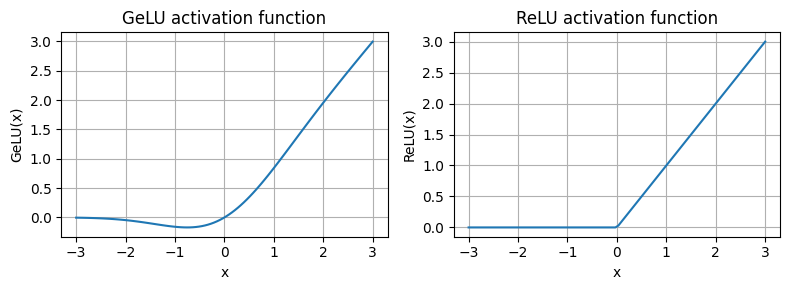

In [46]:
import matplotlib.pyplot as plt

gelu, relu = GeLU(), nn.ReLU()
x = torch.linspace(-3, 3, 100) #A
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GeLU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

- _GeLU_ là 1 hàm phi tuyến có đồ thị mượt hơn so với _ReLU_ tại điểm _x = 0_. 

- Đặc điểm này đồng nghĩa với việc trong quá trình huấn luyện, các nơ-ron nhận đầu vào âm vẫn có thể đóng góp vào quá trình học tập, mặc dù ở mức độ thấp hơn so với các đầu vào dương.

## 4. Feed Forward Network

In [47]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GeLU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )
        
    def forward(self, x):
        return self.layers(x)

## 5. Shortcut Connections

In [48]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            # Implement 5 layers
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GeLU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GeLU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GeLU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GeLU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GeLU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


- Khởi tạo mạng nơ-ron sâu 5 lớp không có _shortcut connections_:

In [49]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)


In [50]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])
    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)
    # Backward pass to calculate the gradients
    loss.backward()
    for name, param in model.named_parameters():
        if 'weight' in name:    
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean()}")

In [51]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606


- Có thể thấy rằng gradient giảm dần từ layer 4 về lại layer 0.

- Sau đây là kết quả của quá trình _backpropagation_ ở mạng nơ-ron sâu 5 lớp có _shortcut connections_:

In [52]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)


layers.0.0.weight has gradient mean of 0.2216978669166565
layers.1.0.weight has gradient mean of 0.20694100856781006
layers.2.0.weight has gradient mean of 0.3289698660373688
layers.3.0.weight has gradient mean of 0.2665731906890869
layers.4.0.weight has gradient mean of 1.3258538246154785


## 6. Transformer Block

In [53]:
class MultiHeadAttention(nn.Module):
    def __init__(self, dim_in, dim_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert dim_out % num_heads == 0, "dim_out must be divisible by num_heads"
        self.dim_out = dim_out
        self.num_heads = num_heads
        self.head_dim = dim_out // num_heads
        self.W_query = nn.Linear(dim_in, dim_out, bias=qkv_bias)
        self.W_key = nn.Linear(dim_in, dim_out, bias=qkv_bias)
        self.W_value = nn.Linear(dim_in, dim_out, bias=qkv_bias)
        self.out_proj = nn.Linear(dim_out, dim_out)         # Output Projection
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )
        
    def forward(self, x):
        batch, num_tokens, dim_in = x.shape 
        keys = self.W_key(x)
        values = self.W_value(x)
        queries = self.W_query(x)
        
        # View
        keys = keys.view(batch, num_tokens, self.num_heads, self.head_dim)
        values = values.view(batch, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(batch, num_tokens, self.num_heads, self.head_dim)
        
        # Transpose from (batch, num_tokens, num_heads, head_dim) to (batch, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)
        queries = queries.transpose(1, 2)
        
        # Compute attention scores
        attention_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        
        attention_scores.masked_fill_(mask_bool, -torch.inf)
        
        attention_weights = torch.softmax(
            attention_scores / keys.shape[-1]**0.5, dim=-1
        )
        attention_weights = self.dropout(attention_weights)
        
        # Compute context vector
        context_vector = (attention_weights @ values).transpose(1, 2)
        
        context_vector = context_vector.contiguous().view(batch, num_tokens, self.dim_out)
        context_vector = self.out_proj(context_vector)
        
        return context_vector

In [54]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.attention = MultiHeadAttention(
            dim_in=cfg["emb_dim"],
            dim_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        
        self.feed_forward = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_resid = nn.Dropout(cfg["drop_rate"])
        
    def forward(self, x):
        # A
        shortcut = x
        x = self.norm1(x)
        x = self.attention(x)
        x = self.drop_resid(x)
        x = x + shortcut
        
        # B
        shortcut = x
        x = self.norm2(x)
        x = self.feed_forward(x)
        x = self.drop_resid(x)
        x = x + shortcut
        
        return x

In [55]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


## 7. GPT model

- Nhờ `DummyGPTModel` đã triển khai ban đầu, `GPTModel` được triển khai khá đơn giản.

In [56]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = LayerNorm(cfg["emb_dim"]) #B
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

- Khởi tạo _mô hình GPT 124M tham số_ sử dụng `GPT_CONFIG_124M`.

In [57]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
text1 = "Every effort moves you"
text2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(text1)))
batch.append(torch.tensor(tokenizer.encode(text2)))
batch = torch.stack(batch, dim=0)   # Merge list to 2D array
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [58]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)


Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


- Trước khi qua phần kế tiếp để triển khai code chuyển đổi các embedding vector này thành văn bản text, ta sẽ tìm hiểu thêm về kiến trúc mô hình và phân tích kích thước của nó.

In [59]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


- Số lượng _parameters_ ở đây là bao gồm:

    + `self.tok_emb`: _vocab\_size * emb\_dim_

    + `self.pos_emb`: _context\_length * emb\_dim_

    + `trf_blocks`: size của tất cả Transformer Block cộng lại

    + `self.out_head`: _emb\_dim * vocab\_size_

- Tại sao ban đầu ta nói sẽ xây dựng _mô hình GPT 124M tham số_ mà thực tế như trên lại 163M? Lý do nằm ở khái niệm `weight tying` (ràng buộc trọng số).

- Khái niệm đó có nghĩa là _GPT-2_ đã tái sử dụng các trọng số từ `layer token embedding` cho `linear output layer` của nó. 

In [60]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


- _Weight tying_ giúp giảm đáng kể bộ nhớ và độ phức tạp thuật toán. Tuy nhiên, nó ép mô hình phải dùng chung một không gian vector cho cả việc "hiểu" (input) và "dự đoán" (output).

- Trong các mô hình lớn ngày nay, việc tách riêng hai lớp này cho phép mô hình linh hoạt hơn:

    + Input Embedding: Tập trung vào việc nắm bắt ngữ nghĩa của từ.

    + Output Head: Tập trung vào việc phân biệt các từ dễ gây nhầm lẫn để đưa ra dự đoán chính xác nhất.

- Tính toán bộ nhớ cho 163M tham số:
    
    + A: Giả định mỗi tham số là một số thực 32-bit (float32), chiếm 4 byte.
    
    + B: Chuyển đổi từ byte sang Megabyte.

In [61]:
total_size_bytes = total_params * 4 #A
total_size_mb = total_size_bytes / (1024 * 1024) #B
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


## 8. Generate text

In [62]:
def generate_text_simple(model, idx, max_new_tokens, context_size): #A
    for _ in range(max_new_tokens):
        # Lấy {context-size} tokens cuối cùng
        idx_cond = idx[:, -context_size:] #B
        with torch.no_grad():
            # Embedding vectors
            logits = model(idx_cond)

        # Lấy embedding vector cuối cùng
        logits = logits[:, -1, :] #C
        
        # Chuyển thành xác suất (từ 0 đến 1, tổng bằng 1)
        probas = torch.softmax(logits, dim=-1) #D
        
        # Lấy index của token có xác suất cao nhất
        idx_next = torch.argmax(probas, dim=-1, keepdim=True) #E
        
        # Ghép vào chuỗi tokens cũ
        idx = torch.cat((idx, idx_next), dim=1) #F

    return idx

- Ở bước sử dụng _softmax_ để chuyển đổi các logits sang phân phối xác suất, từ đó xác định vị trí có giá trị lớn nhất thông qua _torch.argmax_. Hàm softmax có tính đơn điệu, nghĩa là nó bảo toàn thứ tự của các đầu vào khi chuyển đổi thành đầu ra. Vì vậy, trên thực tế, bước softmax là dư thừa vì vị trí có điểm số cao nhất trong tensor đầu ra của softmax cũng chính là vị trí đó trong tensor logit.

- Chúng ta chỉ cần dùng Softmax khi:

    + _Muốn lấy mẫu ngẫu nhiên (Sampling)_: Ví dụ, bạn không muốn luôn lấy từ có xác suất cao nhất (Greedy), mà muốn đôi khi chọn từ có xác suất thấp hơn một chút để văn bản "sáng tạo" hơn. Lúc này bạn cần con số xác suất cụ thể (ví dụ 0.8 và 0.1) để tung xúc xắc.
    
    + _Tính toán Temperature_: Khi bạn muốn điều chỉnh độ "sáng tạo" bằng tham số $T$ (Temperature), bạn phải can thiệp vào công thức Softmax.

- Khởi tạo 1 đoạn text & set _batch=1_:

In [63]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

# .unsqueeze(0) chuyển tensor size (4) thành ([1, 4]) 
encoded_tensor = torch.tensor(encoded).unsqueeze(0) #A
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


- Truyền qua GPT model:

In [77]:
model.eval()    #A
out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=12,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output: ", out)
print("Output length: ", len(out[0]))

Output:  tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267,
         49706, 43231, 47062, 34657, 18631, 49188]])
Output length:  16


- Mapping từ ID token về text:

In [78]:
# Vì nãy đã tăng chiều _batch_ nên phải .squeeze(0) để về tensor 1D array như cũ
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue logger Normandy Compton analogous bore ITV
